## csv를 읽어서 공공 자전거 일별 대여건수 계산 

파일은 웹 검색을 하고 다운로드해서 사용하면 된다.

데이터는 일자별로, 대여건수이이고, 몇 줄만 출력해보면 다음과 같다.

| date| count|

|----------|------|

|2018-01-01| 4950|

|2018-01-02| 7136|

|2018-01-03| 7156|

|2018-01-04| 7102|

|2018-01-05| 7705|

In [1]:
import pyspark
import sys
import os

os.environ["PYSPARK_PYTHON"]=sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"]=sys.executable

myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder\
        .master("local")\
        .appName("myApp")\
        .config(conf=myConf)\
        .getOrCreate()

myDf = spark\
        .read.format('com.databricks.spark.csv')\
        .options(header='true', inferschema='true')\
        .load(os.path.join('data','서울특별시_공공자전거 일별 대여건수_(2018_2019.03).csv'))

In [3]:
myDf.show()

from pyspark.sql import functions as F


myDf =myDf.withColumn('year',F.year('date')).withColumn('month',F.month('date'))


+----------+-----+----+-----+
|      date|count|year|month|
+----------+-----+----+-----+
|2018-01-01| 4950|2018|    1|
|2018-01-02| 7136|2018|    1|
|2018-01-03| 7156|2018|    1|
|2018-01-04| 7102|2018|    1|
|2018-01-05| 7705|2018|    1|
|2018-01-06| 5681|2018|    1|
|2018-01-07| 5220|2018|    1|
|2018-01-08| 6309|2018|    1|
|2018-01-09| 5988|2018|    1|
|2018-01-10| 4476|2018|    1|
|2018-01-11| 4337|2018|    1|
|2018-01-12| 4401|2018|    1|
|2018-01-13| 3756|2018|    1|
|2018-01-14| 4675|2018|    1|
|2018-01-15| 6993|2018|    1|
|2018-01-16| 7421|2018|    1|
|2018-01-17| 6990|2018|    1|
|2018-01-18| 7054|2018|    1|
|2018-01-19| 8329|2018|    1|
|2018-01-20| 6148|2018|    1|
+----------+-----+----+-----+
only showing top 20 rows



### 문제 1-1: 년도별 대여건수 합계

데이터는 2018, 2019년 15개월 간의 대여건수이다. 년도별로 대여건수의 합계를 계산해서 출력하자.

|year|sum(count)|

|----|----------|

|2018|  10124874|

|2019|   1871935|

In [3]:
myDf.groupBy('year').agg({'count':'sum'}).show()

+----+----------+
|year|sum(count)|
+----+----------+
|2018|  10124874|
|2019|   1871935|
+----+----------+



### 문제 1-2: 년도별, 월별 대여건수 합계

년별, 월별로 대여건수를 계산하여 합계를 계산하여 출력한다.


In [4]:
myDf.groupBy('year').pivot('month').agg({'count':'sum'}).show()

+----+------+------+------+------+------+-------+-------+-------+-------+-------+------+------+
|year|     1|     2|     3|     4|     5|      6|      7|      8|      9|     10|    11|    12|
+----+------+------+------+------+------+-------+-------+-------+-------+-------+------+------+
|2018|164367|168741|462661|687885|965609|1207123|1100015|1037505|1447993|1420621|961532|500822|
|2019|495573|471543|904819|  null|  null|   null|   null|   null|   null|   null|  null|  null|
+----+------+------+------+------+------+-------+-------+-------+-------+-------+------+------+



### 문제1-3: 분기별 합계


In [6]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

def a(s):
    if(1<=s and s<=3):
        s = "Q1"
    elif(4<=s and s<=6):
        s = "Q2"
    elif(7<=s and s<=9):
        s = "Q3"
    elif(10<=s and s<=12):
        s = "Q4"
    else:
        s="no"
    return s

quarter_f = udf(a,StringType())
myDf = myDf.withColumn('quarter',quarter_f(myDf.month))

In [7]:
myDf.groupBy('quarter').agg({'count':'sum'}).show()

+-------+----------+
|quarter|sum(count)|
+-------+----------+
|     Q2|   2860617|
|     Q1|   2667704|
|     Q3|   3585513|
|     Q4|   2882975|
+-------+----------+



### 문제1-4: 분기별 평균

In [10]:
myDf.groupBy('quarter').agg({'count':'avg'}).show()

+-------+------------------+
|quarter|        avg(count)|
+-------+------------------+
|     Q2|31435.351648351647|
|     Q1|14820.577777777778|
|     Q3|38972.967391304344|
|     Q4|31336.684782608696|
+-------+------------------+



# Pandas로 풀기 


In [11]:
import pandas as pd
mypd = myDf.toPandas()
mypd.head()

,date,count,year,month,quarter
0,2018-01-01,4950,2018,1,Q1
1,2018-01-02,7136,2018,1,Q1
2,2018-01-03,7156,2018,1,Q1
3,2018-01-04,7102,2018,1,Q1
4,2018-01-05,7705,2018,1,Q1


### 문제 pandas 1: 년도별, 월별 대여건수 합계

In [12]:
mypd.groupby('year').aggregate({'count':'sum'})

,count
year,
2018,10124874
2019,1871935


### 문제 pandas 2:  년도별 x 월별 대여건수 그래프

In [13]:
pd.pivot_table(mypd, values = 'count', index = ['year'], columns= ['month'], aggfunc = 'sum')

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
2018,164367.0,168741.0,462661.0,687885.0,965609.0,1207123.0,1100015.0,1037505.0,1447993.0,1420621.0,961532.0,500822.0
2019,495573.0,471543.0,904819.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 문제 pandas 3:  2018년만 선택해서 년도별 x 분기별 대여건수를 출력해보자.

In [15]:
mypd20 = mypd[mypd['year']==2018]
pd.pivot_table(mypd20, values = 'count', index = ['year'], columns = ['quarter'], aggfunc = 'sum')

quarter,Q1,Q2,Q3,Q4
year,,,,
2018,795769,2860617,3585513,2882975


### 문제 1-5: 년도별, 월별 대여건수 그래프

문제 1-2의 출력을 선 그래프로 그려보자.


<AxesSubplot:>

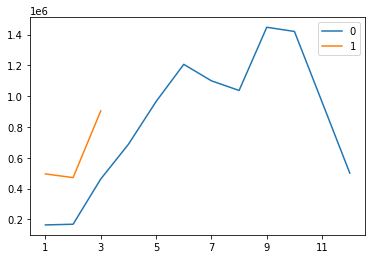

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

ndf = myDf.groupBy('year').pivot('month').agg({'count':'sum'})
pdf = ndf.toPandas()
pdf = pdf.drop('year',1).transpose()

pdf.plot(kind='line')

# graph

In [26]:
marks=[

    "김하나, English, 100",

    "김하나, Math, 80",

    "임하나, English, 70",

    "임하나, Math, 100",

    "김갑돌, English, 82.3",

    "김갑돌, Math, 98.5"

]

In [27]:
import pyspark
import sys
import os

os.environ["PYSPARK_PYTHON"]=sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"]=sys.executable

myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder\
        .master("local")\
        .appName("myApp")\
        .config(conf=myConf)\
        .getOrCreate()

### 1-1 성적데이터로 DataFrame을 생성.



In [29]:
rdd = spark.sparkContext.parallelize(marks)
rdd  = rdd.map(lambda x : x.split(','))
df = spark.createDataFrame(rdd, ['name','subject','score'])
df.show()


+------+--------+-----+
|  name| subject|score|
+------+--------+-----+
|김하나| English|  100|
|김하나|    Math|   80|
|임하나| English|   70|
|임하나|    Math|  100|
|김갑돌| English| 82.3|
|김갑돌|    Math| 98.5|
+------+--------+-----+



### 1-2 zscore 컬럼을 생성.

In [30]:
from pyspark.sql.functions import udf
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType

changetoFloat = udf(lambda x : float(x))
df = df.withColumn('score',changetoFloat(df.score))

calc = df.select(F.mean('score').alias('min'), F.stddev('score').alias('dev')).collect()
mn = calc[0]['min']
dev = calc[0]['dev']

createzscore = udf(lambda x : (x - mn) / dev, FloatType())
df = df.withColumn('zscore', createzscore(df.score))
df.show()

+------+--------+-----+-----------+
|  name| subject|score|     zscore|
+------+--------+-----+-----------+
|김하나| English|100.0| 0.90201485|
|김하나|    Math| 80.0|-0.66217273|
|임하나| English| 70.0| -1.4442666|
|임하나|    Math|100.0| 0.90201485|
|김갑돌| English| 82.3|-0.48229116|
|김갑돌|    Math| 98.5| 0.78470075|
+------+--------+-----+-----------+



### 1-3 cdf 컬럼을 생성.

In [31]:
from scipy.stats import norm

createcdf = udf(lambda x : float(norm.cdf(x)), FloatType())
df = df.withColumn('udf',createcdf(df['score']))
df.show()

+------+--------+-----+-----------+---+
|  name| subject|score|     zscore|udf|
+------+--------+-----+-----------+---+
|김하나| English|100.0| 0.90201485|1.0|
|김하나|    Math| 80.0|-0.66217273|1.0|
|임하나| English| 70.0| -1.4442666|1.0|
|임하나|    Math|100.0| 0.90201485|1.0|
|김갑돌| English| 82.3|-0.48229116|1.0|
|김갑돌|    Math| 98.5| 0.78470075|1.0|
+------+--------+-----+-----------+---+

